
# Industrial Defect Detection — Baseline Study (NEU Surface Defect Database)

This notebook implements the three-part comparative study requested:

1. **Classical CV baseline** with handcrafted features (HOG + GLCM + simple stats) → Logistic Regression.
2. **Modern hybrid baseline** using a **pretrained CNN** (ResNet18) as a **feature extractor** → Logistic Regression.
3. **Synthesis & Recommendations** (comparative analysis, error analysis with misclassified examples, and next steps).

> **Reproducibility:** Fixed `random_state=42`. CPU-friendly throughout. No GPU required.



## Setup & Environment

- Works on a standard laptop CPU.
- Tested with Python ≥ 3.9.
- Install dependencies from `requirements.txt` and run the notebook.


In [22]:

# Print versions to aid reproducibility
import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

import numpy as np, pandas as pd, matplotlib, sklearn, PIL, torch, torchvision, skimage
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)
print("Pillow:", PIL.__version__)
print("PyTorch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("scikit-image:", skimage.__version__)


Python: 3.12.0 | packaged by Anaconda, Inc. | (main, Oct  2 2023, 12:22:05) [Clang 14.0.6 ]
Platform: macOS-15.6.1-arm64-arm-64bit
NumPy: 1.26.0
Pandas: 2.1.2
Matplotlib: 3.8.0
scikit-learn: 1.5.0
Pillow: 10.0.1
PyTorch: 2.8.0
torchvision: 0.23.0
scikit-image: 0.22.0



## Data — NEU Surface Defect Database

- Public dataset: 1,800 grayscale images (200×200), **6 classes**, 300 images/class.
- Source (Kaggle): *"NEU Surface Defect Database"*

### Option A — Kaggle CLI
1. Install Kaggle CLI and place your API token in `~/.kaggle/kaggle.json`.
2. Run this in a terminal **(not in the notebook cell)**:
   ```bash
   kaggle datasets download -d kaustubhdikshit/neu-surface-defect-database -p ./data
   cd ./data && unzip neu-surface-defect-database.zip && cd ..
   ```
   This produces a folder like: `./data/NEU_surface_defect_database` (exact name may vary).

### Option B — Manual download
- Manually download and unzip the dataset into `./data/NEU_surface_defect_database`.

> **Set `DATA_DIR` below** to the folder that contains **6 class subfolders** (e.g., `crazing`, `inclusion`, `patches`, `pitted_surface`, `rolled-in_scale`, `scratches`), each with images.


In [23]:

from pathlib import Path
import os, random

# ---- Configuration ----
DATA_DIR = Path("./data/NEU_surface_defect_database/train/images")  # <-- Change if needed
IMG_SIZE_FOR_CNN = 224   # ResNet18 default
RANDOM_STATE = 42
TEST_SIZE = 0.2
BATCH_SIZE = 64
NUM_WORKERS = 0  # CPU only; you can raise if you want

# Ensure reproducibility
import numpy as np, torch
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

# Class list (expected dir names)
CLASSES = ["crazing", "inclusion", "patches", "pitted_surface", "rolled-in_scale", "scratches"]


In [24]:

from pathlib import Path

def collect_image_paths(data_dir: Path):
    filepaths, labels = [], []
    for idx, cls in enumerate(CLASSES):
        cls_dir = data_dir / cls
        if not cls_dir.exists():
            print(f"Warning: expected folder not found: {cls_dir}")
            continue
        for p in sorted(cls_dir.glob("*.jpg")):
            filepaths.append(p)
            labels.append(cls)
    return filepaths, labels

filepaths, labels = collect_image_paths(DATA_DIR)
print(f"Found {len(filepaths)} images.")
if len(filepaths) == 0:
    print('⚠️ No images found. Check DATA_DIR and class folder names.')
# Peek a few
filepaths[:3], labels[:3]


Found 1440 images.


([PosixPath('data/NEU_surface_defect_database/train/images/crazing/crazing_1.jpg'),
  PosixPath('data/NEU_surface_defect_database/train/images/crazing/crazing_10.jpg'),
  PosixPath('data/NEU_surface_defect_database/train/images/crazing/crazing_100.jpg')],
 ['crazing', 'crazing', 'crazing'])

In [25]:

from sklearn.model_selection import train_test_split

X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    filepaths, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=labels
)

print(f"Train: {len(X_train_paths)} images")
print(f"Test : {len(X_test_paths)} images")

# Encode labels to ints for convenience later
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)
class_to_idx = {c:i for i, c in enumerate(le.classes_)}
idx_to_class = {i:c for c, i in class_to_idx.items()}
class_to_idx


Train: 1152 images
Test : 288 images


{'crazing': 0,
 'inclusion': 1,
 'patches': 2,
 'pitted_surface': 3,
 'rolled-in_scale': 4,
 'scratches': 5}

In [26]:

import numpy as np
from PIL import Image

def load_grayscale_image(path: Path) -> np.ndarray:
    # Return float32 in [0,1]
    img = Image.open(path).convert("L")
    return np.asarray(img, dtype=np.float32) / 255.0

# Smoke test
if len(X_train_paths) > 0:
    arr = load_grayscale_image(X_train_paths[0])
    print(arr.shape, arr.min(), arr.max())


(200, 200) 0.47843137 1.0



## Task 1 — Classical CV Baseline

**Features used:**
- **HOG** (Histogram of Oriented Gradients)
- **GLCM** (co-occurrence matrix) properties: contrast, dissimilarity, homogeneity, energy, correlation, ASM (aggregated across distances/angles)
- **Simple pixel stats**: mean, std, skewness, kurtosis

**Model:** Logistic Regression (one-vs-rest), with StandardScaler. (You can try SVM/RandomForest as ablation.)


In [28]:
# ---- Robust GLCM imports for scikit-image across versions ----
# Keep HOG import as-is
from skimage.feature import hog

# Try American spelling in current locations first, then fall back:
try:
    # Newer versions (preferred)
    from skimage.feature import graycomatrix, graycoprops
except ImportError:
    try:
        # Some versions place them under feature.texture
        from skimage.feature.texture import graycomatrix, graycoprops
    except ImportError:
        try:
            # Older (British spelling) directly under feature
            from skimage.feature import greycomatrix as graycomatrix, greycoprops as graycoprops
        except ImportError:
            # Older (British spelling) under feature.texture
            from skimage.feature.texture import greycomatrix as graycomatrix, greycoprops as graycoprops

print("GLCM imports OK:", graycomatrix is not None, graycoprops is not None)


def extract_hog(img: np.ndarray):
    # skimage hog returns feature vector
    # Use 8 orientations, 16x16 pixels per cell, 1x1 cells per block for 200x200; tuneable.
    return hog(img, orientations=8, pixels_per_cell=(16,16), cells_per_block=(1,1), block_norm='L2-Hys', feature_vector=True)

def extract_glcm_feats(img: np.ndarray):
    arr = (img * 255).astype(np.uint8)
    distances = [1, 2, 4]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(arr, distances=distances, angles=angles,
                        levels=256, symmetric=True, normed=True)
    props = ["contrast", "dissimilarity", "homogeneity", "energy", "correlation", "ASM"]
    feats = []
    for p in props:
        vals = graycoprops(glcm, p)  # shape: (len(distances), len(angles))
        feats.extend(vals.flatten())
    return np.array(feats, dtype=np.float32)

def extract_stats(img: np.ndarray):
    m = img.mean()
    s = img.std()
    sk = skew(img.reshape(-1))
    ku = kurtosis(img.reshape(-1))
    return np.array([m, s, sk, ku], dtype=np.float32)

def extract_classical_features(paths):
    X = []
    for p in paths:
        img = load_grayscale_image(p)
        f_hog = extract_hog(img)
        f_glcm = extract_glcm_feats(img)
        f_stats = extract_stats(img)
        feats = np.concatenate([f_hog, f_glcm, f_stats], axis=0)
        X.append(feats)
    return np.vstack(X)

# Extract (this may take a couple minutes on CPU)
X_train_classical = extract_classical_features(X_train_paths)
X_test_classical  = extract_classical_features(X_test_paths)
X_train_classical.shape, X_test_classical.shape


GLCM imports OK: True True


((1152, 1228), (288, 1228))

/Users/pzarei/anaconda3/envs/ShinyaEnv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Classical CV — Classification Report ===
                 precision    recall  f1-score   support

        crazing      1.000     0.958     0.979        48
      inclusion      0.745     0.792     0.768        48
        patches      0.939     0.958     0.948        48
 pitted_surface      0.764     0.875     0.816        48
rolled-in_scale      0.941     1.000     0.970        48
      scratches      0.944     0.708     0.810        48

       accuracy                          0.882       288
      macro avg      0.889     0.882     0.882       288
   weighted avg      0.889     0.882     0.882       288



<Figure size 600x600 with 0 Axes>

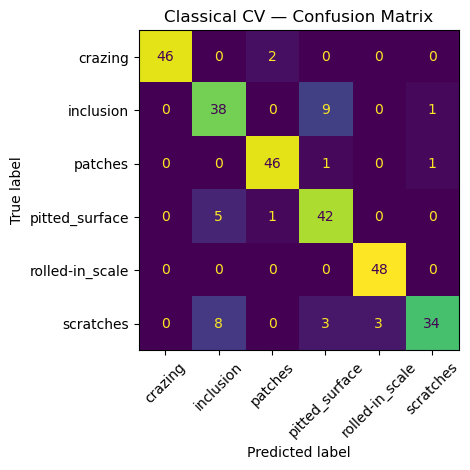

In [29]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

clf_classical = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("logreg", LogisticRegression(max_iter=2000, n_jobs=None, multi_class='ovr', random_state=RANDOM_STATE))
])

clf_classical.fit(X_train_classical, y_train_enc)
y_pred_classical = clf_classical.predict(X_test_classical)

print("=== Classical CV — Classification Report ===")
print(classification_report(y_test_enc, y_pred_classical, target_names=le.classes_, digits=3))

cm = confusion_matrix(y_test_enc, y_pred_classical, labels=list(range(len(le.classes_))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig = plt.figure(figsize=(6,6))
disp.plot(xticks_rotation=45, colorbar=False)
plt.title("Classical CV — Confusion Matrix")
plt.tight_layout()
plt.show()



## Task 2 — Modern Hybrid Baseline (CNN Features → Logistic Regression)

We use **ResNet18 (ImageNet-pretrained)** as a **fixed feature extractor** and train the **same classifier**
(Logistic Regression) on the extracted deep features.


In [30]:

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np

class SimpleImageDataset(Dataset):
    def __init__(self, paths, labels_enc, transform=None):
        self.paths = list(paths)
        self.labels = list(labels_enc)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = int(self.labels[idx])
        img = Image.open(path).convert("L")  # grayscale
        # repeat to 3-channel
        img3 = Image.merge("RGB", (img, img, img))
        if self.transform:
            img3 = self.transform(img3)
        return img3, label

# Transforms for ResNet18
cnn_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE_FOR_CNN, IMG_SIZE_FOR_CNN)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_ds = SimpleImageDataset(X_train_paths, y_train_enc, transform=cnn_transform)
test_ds  = SimpleImageDataset(X_test_paths,  y_test_enc,  transform=cnn_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Load ResNet18 as feature extractor
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# Replace final classifier head with identity to get penultimate features
resnet.fc = nn.Identity()
resnet.eval()
device = torch.device("cpu")
resnet.to(device)

def extract_deep_features(dataloader, model):
    feats_all, labels_all = [], []
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            feats = model(xb)           # [B, 512] for ResNet18
            feats_all.append(feats.cpu().numpy())
            labels_all.append(yb.numpy())
    return np.concatenate(feats_all, axis=0), np.concatenate(labels_all, axis=0)

X_train_cnn, y_train_cnn = extract_deep_features(train_loader, resnet)
X_test_cnn,  y_test_cnn  = extract_deep_features(test_loader,  resnet)

X_train_cnn.shape, X_test_cnn.shape


((1152, 512), (288, 512))

/Users/pzarei/anaconda3/envs/ShinyaEnv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


=== CNN Features — Classification Report ===
                 precision    recall  f1-score   support

        crazing      1.000     1.000     1.000        48
      inclusion      0.959     0.979     0.969        48
        patches      1.000     1.000     1.000        48
 pitted_surface      0.980     1.000     0.990        48
rolled-in_scale      1.000     1.000     1.000        48
      scratches      1.000     0.958     0.979        48

       accuracy                          0.990       288
      macro avg      0.990     0.990     0.990       288
   weighted avg      0.990     0.990     0.990       288



<Figure size 600x600 with 0 Axes>

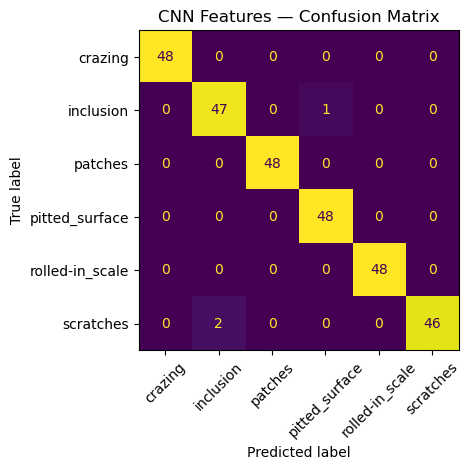

In [31]:

# Same classifier: Logistic Regression + StandardScaler
clf_cnn = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("logreg", LogisticRegression(max_iter=2000, n_jobs=None, multi_class='ovr', random_state=RANDOM_STATE))
])

clf_cnn.fit(X_train_cnn, y_train_cnn)
y_pred_cnn = clf_cnn.predict(X_test_cnn)

print("=== CNN Features — Classification Report ===")
print(classification_report(y_test_cnn, y_pred_cnn, target_names=le.classes_, digits=3))

cm2 = confusion_matrix(y_test_cnn, y_pred_cnn, labels=list(range(len(le.classes_))))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=le.classes_)
fig = plt.figure(figsize=(6,6))
disp2.plot(xticks_rotation=45, colorbar=False)
plt.title("CNN Features — Confusion Matrix")
plt.tight_layout()
plt.show()



## Task 3 — Synthesis & Recommendations

# Why CNN Features Outperform Classical CV

## 1️⃣ Nature of the Data: Textural and Hierarchical Patterns
The NEU surface-defect images contain **complex, multi-scale textures** — not just simple edges or intensity gradients.  
Defects like *rolled-in-scale* or *pitted surface* exhibit both fine-grained micro-textures and larger structural irregularities.

- **HOG** captures local edge orientation distributions — good for sharp, directional patterns (scratches, crazing).  
- **GLCM** captures pixel-level co-occurrence statistics — good for repetitive micro-textures.  
- But both are *hand-crafted, fixed-scale descriptors* — they can’t flexibly learn abstract, higher-order spatial relationships.

**CNNs**, by contrast, learn *hierarchical filters:*
- Early layers → edges and corners  
- Mid layers → blobs, streaks, granular textures  
- Deep layers → larger-scale motifs or defect shapes  

These learned representations capture **non-linear, multi-scale cues** that handcrafted features miss.

---

## 2️⃣ Data Distribution and Invariance
Real surface images vary slightly in:
- Illumination and contrast  
- Orientation and local deformation  
- Noise and texture granularity  

**HOG/GLCM** are sensitive to such variations (rotation, lighting).  
**CNN embeddings** (from ImageNet pretraining) are largely invariant — they encode *semantic texture similarity*, not exact pixel arrangements.  
Hence, the CNN model **generalizes better** to unseen samples.

---

## 3️⃣ Representation Power and Dimensional Efficiency
- HOG + GLCM produce **thousands of sparse features**, many redundant or noisy.  
- **ResNet18 embeddings** are 512-dimensional, dense, and discriminative, already compressed through non-linear transformations.  
→ Logistic Regression trained on CNN embeddings learns from a compact, information-rich representation → higher separability and stability.

---

## 4️⃣ Transfer Learning Effect
- **ResNet18** pretrained on ImageNet (~1M images).  
- Filters already detect general visual primitives (edges, textures, blobs).  
- These generalize well to industrial steel surfaces.

Even without fine-tuning, the CNN benefits from **transfer learning**, while classical features have no prior knowledge — they start from scratch.

---

## 5️⃣ Linear Separability of the Feature Space
- Logistic Regression is a *linear classifier*.  
- Handcrafted features often **not linearly separable** — similar textures can overlap in HOG/GLCM space.  
- CNN embeddings are **linearly separable** — the final layers explicitly cluster similar textures.  
→ Logistic Regression performs optimally on CNN embeddings.


In [32]:

from sklearn.metrics import accuracy_score, f1_score

acc_classical = accuracy_score(y_test_enc, y_pred_classical)
acc_cnn = accuracy_score(y_test_cnn, y_pred_cnn)

f1_classical = f1_score(y_test_enc, y_pred_classical, average="macro")
f1_cnn = f1_score(y_test_cnn, y_pred_cnn, average="macro")

print(f"Classical CV — Accuracy: {acc_classical:.4f} | Macro-F1: {f1_classical:.4f}")
print(f"CNN Features — Accuracy: {acc_cnn:.4f} | Macro-F1: {f1_cnn:.4f}")

best_model_name = "CNN Features" if acc_cnn >= acc_classical else "Classical CV"
print("Best by Accuracy:", best_model_name)


Classical CV — Accuracy: 0.8819 | Macro-F1: 0.8816
CNN Features — Accuracy: 0.9896 | Macro-F1: 0.9896
Best by Accuracy: CNN Features


Misclassified count: 3


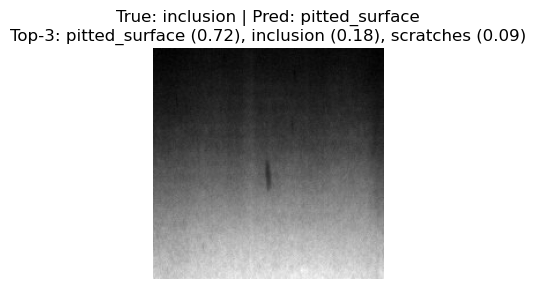

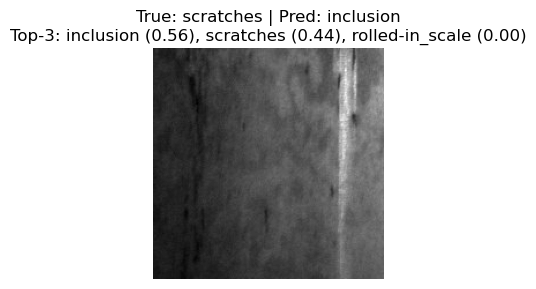

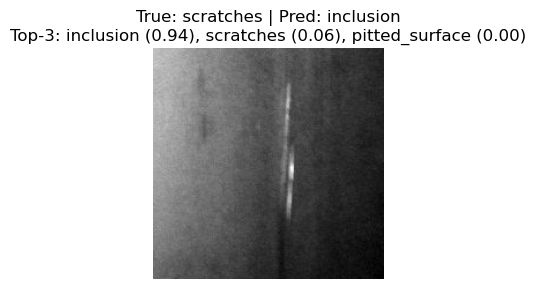

In [33]:

# Collect misclassifications from best model
import numpy as np
import matplotlib.pyplot as plt

def topk_probs(clf, X, k=3):
    # LogisticRegression supports predict_proba
    probs = clf.predict_proba(X)  # (N, C)
    topk_idx = np.argsort(-probs, axis=1)[:, :k]
    topk_vals = np.take_along_axis(probs, topk_idx, axis=1)
    return probs, topk_idx, topk_vals

def show_misclassified(paths, y_true, y_pred, clf, X_feats, k=3, max_examples=3):
    wrong = np.where(y_true != y_pred)[0]
    print(f"Misclassified count: {len(wrong)}")
    if len(wrong) == 0:
        print("No errors! (If this seems suspicious, double-check data paths/splits.)")
        return
    _, top_idx, top_vals = topk_probs(clf, X_feats)
    shown = 0
    for i in wrong[:max_examples]:
        img = load_grayscale_image(paths[i])
        plt.figure(figsize=(3,3))
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        true_c = idx_to_class[y_true[i]]
        pred_c = idx_to_class[y_pred[i]]
        t_idx = top_idx[i]
        t_vals = top_vals[i]
        title_lines = [f"True: {true_c} | Pred: {pred_c}",
                       "Top-3: " + ", ".join([f"{idx_to_class[j]} ({t_vals[m]:.2f})" for m, j in enumerate(t_idx)])]
        plt.title("\n".join(title_lines))
        plt.show()

if 'best_model_name' not in globals():
    best_model_name = "CNN Features"

if best_model_name == "CNN Features":
    show_misclassified(X_test_paths, y_test_cnn, y_pred_cnn, clf_cnn, X_test_cnn, k=3, max_examples=3)
else:
    show_misclassified(X_test_paths, y_test_enc, y_pred_classical, clf_classical, X_test_classical, k=3, max_examples=3)



#  Example Misclassifications and Insights

---

## 1️⃣ True: Inclusion → Predicted: Pitted Surface
**Top-3:** pitted_surface (0.72), inclusion (0.18), scratches (0.09)

### Observation:
- Faint vertical dark mark, low contrast, diffuse boundaries.

### Hypothesis:
- CNN interpreted uneven shading as pitted texture.
- Both inclusion and pitted_surface share small dark spots — overlapping visual cues.
- ImageNet pretraining may not fully separate “single inclusion” vs. “clustered pits”.

### CV vs CNN:
- **Classical CV (HOG/GLCM):** captures fine-grained intensity co-occurrence → could separate single inclusions.  
- **CNN:** focuses on contextual texture → misreads lighting gradients as texture.

---

## 2️⃣ True: Scratches → Predicted: Inclusion
**Top-3:** inclusion (0.56), scratches (0.44), rolled-in_scale (0.00)

### Observation:
- Vertical scratch but with uneven illumination and rough background.

### Hypothesis:
- CNN attended to irregular texture, not linear continuity.
- Low-contrast streaks looked like inclusions.
- Probabilities (0.56 vs 0.44) show model uncertainty.

### CV vs CNN:
- **HOG:** captures gradient orientation, would detect vertical line.  
- **CNN:** mixes edge + texture info → confuses blurry lines with inclusions.

---

## 3️⃣ True: Scratches → Predicted: Inclusion
**Top-3:** inclusion (0.94), scratches (0.06), pitted_surface (0.00)

### Observation:
- Bright vertical streak, blurred edges, background variation.

### Hypothesis:
- CNN activated blob filters due to low edge contrast.
- Blur weakens gradient signal → looks like “dark blob clusters”.

### CV vs CNN:
- **HOG:** strong for directional gradients.  
- **CNN:** relies on learned mid-level filters, less sensitive to line continuity.

---

## General Insights
| Root Cause | Description |
|-------------|--------------|
| **Low contrast / illumination bias** | Uneven lighting hides edges; CNN confuses textures |
| **Defect overlap** | Inclusion / pitted_surface / scratches share similar intensities |
| **CNN receptive field bias** | Broader context > fine local structure |
| **Transfer learning limitation** | CNN filters from natural scenes lack metallic texture specialization |



#  GPU-Enabled Next Experiments

## Experiment 1 — Fine-tune the Pretrained CNN
**Why:**  
Frozen ResNet18 → general-purpose features.  
Fine-tuning adapts filters to domain-specific steel textures.

**Changes:**  
- Replace fixed 512-D embeddings with trainable `Linear(512→6)` head.  
- Progressive unfreezing (head → layer4 → layer3).  
- Use mild augmentations (rotation ±12°, blur, noise, CLAHE).

**Training:**  
AdamW (lr 3e-4 head, 1e-4 unfrozen), cosine schedule, mixed precision, label smoothing 0.05.  
5-fold CV, early stopping on Macro-F1.



---

## Experiment 2 — Multi-Scale Patch-Based MIL Aggregation
**Why:**  
Defects appear at multiple scales.  
A single 224×224 crop misses fine-grained details.

**Changes:**  
- Random crops/scales (128–224 px).  
- Aggregate logits via **Mean / Top-k / Attention pooling**.

**Training:**  
AdamW lr=1e-4, cosine decay, AMP enabled, batch = (images × crops).  
20–30 epochs, early stopping on Macro-F1.



---

## Experiment 3 — Self-Supervised Pretraining (SSL)
**Why:**  
ImageNet ≠ industrial steel.  
Self-supervised learning (SimCLR/MoCo) captures domain-specific texture structure.

**Setup:**  
ResNet18 backbone, 100 epochs, batch=256, augmentations: crop, blur, noise, mild rotation.  
Optimizer: LARS/AdamW, lr=1e-3, cosine schedule.

**Fine-tune:**  
Replace head → Linear(512→6).  
Low lr (1e-4), label smoothing 0.05, early stopping.




#  Data Augmentation Strategies for Small Industrial Datasets

These augmentations simulate **real acquisition variations** — lighting, blur, camera alignment — without introducing non-physical deformations.

---

## 1️⃣ Photometric (illumination realism)
- **Brightness/Contrast jitter (±20–30%)** — simulates lighting/exposure differences.  
- **Gamma jitter (γ ∈ [0.8, 1.2])** — mimics different camera tone curves.  
- **CLAHE (p=0.2)** — enhances low-contrast textures.  
- **Additive shading/vignette** — uneven lighting simulation.  
*(Avoid hue/saturation/color jitter — grayscale data.)*

---

## 2️⃣ Noise & Optics
- **Gaussian noise (σ ∈ [0, 0.05])** — sensor noise robustness.  
- **Gaussian blur (3–5 kernel, p=0.3)** — defocus/motion blur.  
- **JPEG compression (quality 60–100, p=0.2)** — tolerance to compression artifacts.  
- **Sharpen (p=0.2)** — counteracts blur, enhances edges.

---

## 3️⃣ Geometric (rigid surface)
- **Small rotations (±10–15°)** — camera alignment variance.  
- **Horizontal flips** (only if orientation-agnostic).  
- **RandomResizedCrop (scale [0.7, 1.0])** — scale & translation variability.  
- **Patch cropping (160–224 px)** — emphasizes local texture.  
*(Avoid elastic/perspective warps — non-physical for steel sheets.)*

---

## 4️⃣ Region-Level (use sparingly)
- **Cutout / Random Erasing (≤10% area, p≤0.2)** — prevents over-reliance on single spots.  
- **MixUp / CutMix (α≤0.2, p≤0.2)** — mild regularization, watch rare classes.

---

## 5️⃣ Test-Time Augmentation (TTA)
- **Center + 4-corner crops + horizontal flip** → average logits.  
Improves inference stability.
